# Backtester

In [39]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../lib/stockPredictor'))
if module_path not in sys.path:
    sys.path.append(module_path)
from stockPredictor import StockPredictor 


## Config


In [40]:
np.set_printoptions(threshold=50, edgeitems=20)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
from IPython.display import HTML

In [41]:
index='Timestamp'
# index='time_period_start'
sample_size=60000
PATH='../data/stock/'

In [42]:
# # train.to_csv(f'{PATH}test.csv', sep=',', encoding='utf-8')

# p = StockPredictor(pd.DataFrame(), index)
# p.read_from_feather(PATH)
# p.train

## Create datasets

In [43]:
table_names = [
#         'btc-bitstamp-2012-01-01_to_2018-01-08'
#     'BTC_COINBASE_2018-07-25_09-06'
#     'ETH_COINBASE_07-21_08-24'
#     'COINBASE_BCH_2018-06-15_09-01'
#     'COINBASE_BTC_2017-11-01_01-09'
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27'
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11',
#     'bitstamp_07-09'
#     'btc_historical_parsed'
]

In [44]:
tables = [pd.read_csv(PATH + fname + '.csv', low_memory=False) for fname in table_names]

In [45]:
# for t in tables: display(t.head())

In [46]:
train= tables[0]
train

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1417412280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1417412340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1417412400,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
8,1417412460,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1417412520,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
p = StockPredictor(train, index)
p.sample_train(sample_size)
# p.train = p.train.head(100000)
p.normalize_train('Volume_(BTC)','Open','High','Low','Close', 'Weighted_Price')
p.train

Train size: 60000 Original size: 2016354


,Timestamp,Volume,Open,High,Low,Close,Weighted_Price
1956354,1538294460,0.992991,6568.21,6568.22,6568.21,6568.22,6568.215437
1956355,1538294520,0.168090,6568.22,6569.52,6568.21,6569.52,6568.726485
1956356,1538294580,0.801465,6569.51,6569.52,6569.51,6569.52,6569.512209
1956357,1538294640,0.549007,6569.51,6569.52,6569.51,6569.52,6569.516567
1956358,1538294700,0.657151,6569.51,6569.52,6569.51,6569.51,6569.518713
1956359,1538294760,1.458257,6569.51,6569.52,6569.51,6569.52,6569.510382
1956360,1538294820,10.473524,6569.51,6569.51,6564.12,6568.03,6568.441890
1956361,1538294880,0.150769,6565.60,6566.72,6563.06,6566.72,6565.467770
1956362,1538294940,1.063495,6566.71,6566.72,6566.71,6566.72,6566.717178
1956363,1538295000,0.320144,6566.71,6566.72,6566.71,6566.72,6566.711365


## Change Point Analysis Setup

In [48]:
# ! pip install ruptures
import ruptures as rpt
import matplotlib.pyplot as plt

In [49]:
signal_df = pd.DataFrame({
    'Close':p.train.Close,
    'Volume':p.train.Volume
})[['Close','Volume']]
signal = signal_df.values

#### Binary Segmentation

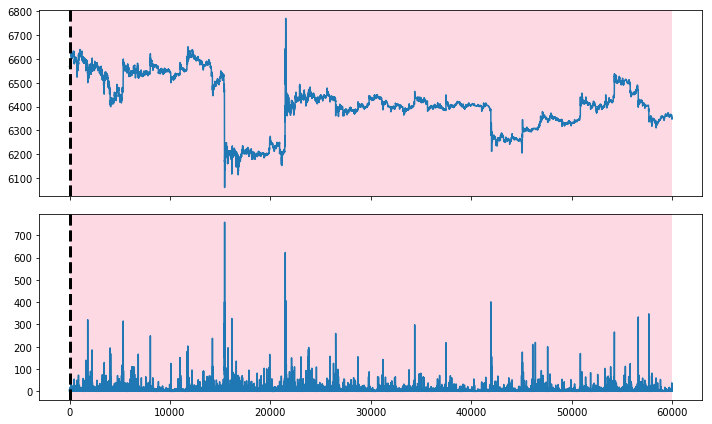

In [50]:
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, my_bkps, my_bkps, figsize=(10, 6))
plt.show()

In [51]:
my_bkps

[5, 60000]

#### Window Based

/usr/local/lib/python3.5/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/usr/local/lib/python3.5/dist-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


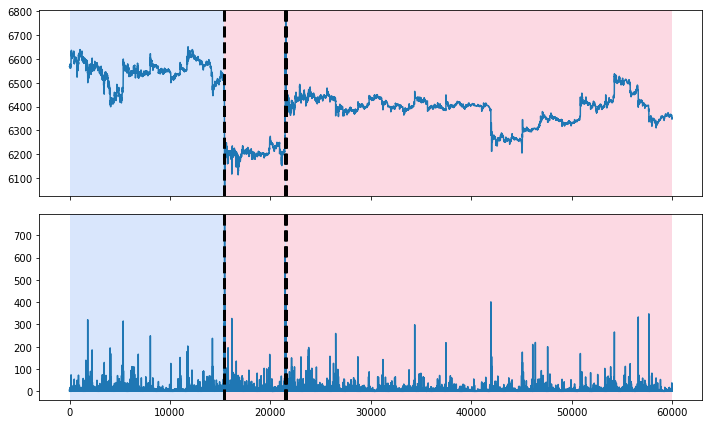

In [52]:
# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=40, model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, my_bkps, my_bkps, figsize=(10, 6))
plt.show()

In [53]:
my_bkps

[15425, 21480, 21545, 60000]